In [1]:
import torch
import numpy

In [2]:
import sys

sys.path.append('../')
sys.path.append('../model')

In [3]:
from classifiers import EncoderClassifier, EncoderClassifierConfig
from training import run_training
from encoder import create_model, add_arguments
from esm_train import get_esm, device, parser
from data_loading import prepare_datasets

/storage/praha1/home/nexuso1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [4]:
add_arguments(parser)

In [5]:
chkpt_path = '../model/new_logs/encoder_S_60_focal/fold_0/chkpt.ckpt'
checkpoint = torch.load(chkpt_path)

In [6]:
args = parser.parse_args(args=[])

In [7]:
for k, v in checkpoint['hyper_parameters'].items():
    args.__setattr__(k, v)
    
args

Namespace(seed=42, batch_size=16, epochs=20, prot_info_path='../data/phosphosite_sequences/phosphosite_df.json', dataset_path='../data/splits_S.json', weight_decay=0.0001, accum=2, hidden_size=128, lr=3e-05, o='encoder_S_60_focal', n='esm', compile=False, lora=False, dropout=0.5, type='35M', pos_weight=0.6, num_workers=15, n_layers=1, checkpoint_path=None, model_path=None, focal=False, residues="['S']", ignore_label=-1, patience=15, debug=False, n_layers_mlp=3, block_size=1, cnn_type='basic', expand_m=4, sr_n=3, sr_kernel_size=3, sr_init_size=256, sr_final_size=256, res_kernel_size=31, sr_type='cnn', encoder_dim=256, ffw_dim=2048, expand=4, logdir='new_logs/encoder_S_60_focal')

In [8]:
args.batch_size=16

In [22]:
model, tokenizer = create_model(args)


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EncoderClassifier(
  (base): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, element

In [10]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [13]:
from torch import Tensor
from typing import Optional
class FixedEncoderLayer(torch.nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(FixedEncoderLayer, self).__init__(*args, **kwargs)
        self.last_attn_weight = 0
        
    # self-attention block
    def _sa_block(
        self,
        x: Tensor,
        attn_mask: Optional[Tensor],
        key_padding_mask: Optional[Tensor],
        is_causal: bool = False,
    ) -> Tensor:
        x, attn_weights = self.self_attn(
            x,
            x,
            x,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=True,
            is_causal=is_causal,
        )
        print(attn_weights)
        self.last_attn_weight = attn_weights
        return self.dropout1(x)

    def copy_weights_from(self, other_layer):
        if not isinstance(other_layer, torch.nn.TransformerEncoderLayer):
            raise ValueError("Expected an instance of nn.TransformerEncoderLayer")
        
        self.self_attn.load_state_dict(other_layer.self_attn.state_dict())
        self.linear1.load_state_dict(other_layer.linear1.state_dict())
        self.linear2.load_state_dict(other_layer.linear2.state_dict())
        self.norm1.load_state_dict(other_layer.norm1.state_dict())
        self.norm2.load_state_dict(other_layer.norm2.state_dict())
        self.dropout1.load_state_dict(other_layer.dropout1.state_dict())
        self.dropout2.load_state_dict(other_layer.dropout2.state_dict())
        self.activation = other_layer.activation


In [14]:
for i in range(len(model.encoder.layers)):
    module = model.encoder.layers[i]
    if isinstance(module, torch.nn.TransformerEncoderLayer):
        print(module)
        enc_dim = args.encoder_dim
        ffw_dim = args.ffw_dim
        new_instance = FixedEncoderLayer(d_model = enc_dim, dim_feedforward=ffw_dim, nhead=8, batch_first=True)
        new_instance.copy_weights_from(module)
        model.encoder.layers[i] = new_instance

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (linear1): Linear(in_features=256, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=256, bias=True)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


In [15]:
from training import LightningWrapper
from torchmetrics import F1Score, MatthewsCorrCoef, Precision, Recall, AUROC, \
MeanMetric, AveragePrecision, PrecisionRecallCurve, MetricCollection
from torch.utils.data import DataLoader
from functools import partial
from data_loading import prep_batch

In [16]:
model

EncoderClassifier(
  (base): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, element

In [17]:
full_dataset = prepare_datasets(args, ignore_label=args.ignore_label)

step_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
})

epoch_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
    'auroc' : AUROC('binary', ignore_index=args.ignore_label),
    'auprc' : AveragePrecision('binary', ignore_index=args.ignore_label),
    'mcc' : MatthewsCorrCoef('binary', ignore_index=args.ignore_label)
})

In [18]:
train_ds, dev_ds, test_ds = full_dataset.get_fold(0)

train = DataLoader(train_ds, args.batch_size, shuffle=True,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False, 
                    num_workers=args.num_workers )
dev = DataLoader(dev_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

test = DataLoader(test_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

Train size: 7180
Dev size: 1796
Test size: 2244


In [23]:
model = LightningWrapper(args, model, step_metrics=step_metrics, epoch_metrics=epoch_metrics, ds_size=len(train), logdir='.')

In [24]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [25]:
#handle = model.classifier.encoder.layers[0].self_attn.register_forward_hook(hook)

In [26]:
#handle.remove()
import lightning as L
trainer = L.Trainer()
model.logdir = '.'
trainer.test(model, test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-a499a47b-6eca-00c0-ef67-07b64dce9e09]


Testing DataLoader 0: 100%|██████████| 141/141 [00:35<00:00,  3.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_auprc         │    0.6935030221939087     │
│        test_auroc         │    0.8387981653213501     │
│          test_f1          │    0.5957019329071045     │
│         test_loss         │    0.3552580177783966     │
│      test_loss_mean       │    0.3552580177783966     │
│         test_mcc          │    0.5560073256492615     │
│      test_precision       │    0.7883375883102417     │
│        test_recall        │    0.4787227511405945     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3552580177783966,
  'test_loss_mean': 0.3552580177783966,
  'test_f1': 0.5957019329071045,
  'test_precision': 0.7883375883102417,
  'test_recall': 0.4787227511405945,
  'test_auprc': 0.6935030221939087,
  'test_auroc': 0.8387981653213501,
  'test_mcc': 0.5560073256492615}]

In [28]:
model.eval()
model.to(torch.device('cuda:0'))
test_batch = next(iter(test))

In [29]:
test_batch

{'input_ids': tensor([[ 0, 20, 11,  ...,  1,  1,  1],
        [ 0, 20,  6,  ...,  1,  1,  1],
        [ 0, 20,  7,  ...,  1,  1,  1],
        ...,
        [ 0, 20, 13,  ...,  1,  1,  1],
        [ 0, 20,  4,  ...,  1,  1,  1],
        [ 0, 20,  8,  ...,  1,  1,  1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1.,  0.,  ..., -1., -1., -1.]]), 'batch_lens': tensor([117, 138, 363, 215, 676,  74, 619, 597, 959, 185, 408, 729, 278, 258,
        358, 892]), 'indices': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15

In [31]:
with torch.no_grad():
    out = model.classifier.predict(**test_batch.to(torch.device('cuda:0')))

out

(tensor(0.3534, device='cuda:0'),
 tensor([[[ 1.2892],
          [-0.1648],
          [12.2891],
          ...,
          [-0.1968],
          [-0.1968],
          [-0.1968]],
 
         [[ 9.3806],
          [ 5.9131],
          [ 5.4615],
          ...,
          [-0.1968],
          [-0.1968],
          [-0.1968]],
 
         [[10.0446],
          [-5.7500],
          [ 3.9518],
          ...,
          [-0.1968],
          [-0.1968],
          [-0.1968]],
 
         ...,
 
         [[11.6717],
          [ 3.9674],
          [ 9.9622],
          ...,
          [-0.1968],
          [-0.1968],
          [-0.1968]],
 
         [[-0.3966],
          [-4.3590],
          [ 2.6864],
          ...,
          [-0.1968],
          [-0.1968],
          [-0.1968]],
 
         [[-8.4586],
          [-8.8090],
          [-8.5777],
          ...,
          [-0.1968],
          [-0.1968],
          [-0.1968]]], device='cuda:0'))

In [25]:
weights = model.classifier.encoder.layers[0].last_attn_weight

0

In [23]:
import matplotlib.pyplot as plt

In [26]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import seaborn as sns

sns.heatmap(weights.cpu().numpy())

AttributeError: 'int' object has no attribute 'cpu'

In [35]:
pos_indices = torch.argwhere(test_batch['labels'] == 1)
neg_indices = torch.argwhere(test_batch['labels'] == 0)

In [36]:
pos_indices

tensor([[  0, 237],
        [  1,  42],
        [  1,  44],
        [  1,  45],
        [  1,  55],
        [  1, 134],
        [  1, 201],
        [  1, 283],
        [  1, 396],
        [  1, 508],
        [  1, 519],
        [  1, 522],
        [  1, 533],
        [  1, 540],
        [  1, 541],
        [  1, 554],
        [  2,  43],
        [  2,  46],
        [  2,  52],
        [  2,  58],
        [  2,  68],
        [  2,  71],
        [  2, 102],
        [  2, 202],
        [  2, 225],
        [  2, 265],
        [  2, 270],
        [  2, 280],
        [  2, 316],
        [  2, 351],
        [  2, 355],
        [  2, 357],
        [  2, 358],
        [  2, 396],
        [  2, 403],
        [  2, 406],
        [  2, 413],
        [  2, 416],
        [  2, 417],
        [  2, 664],
        [  2, 767],
        [  2, 777],
        [  2, 812],
        [  2, 862],
        [  2, 863],
        [  3,  24],
        [  3,  88],
        [  3,  89],
        [  3, 100],
        [  3, 123],


In [37]:
neg_indices

tensor([[  0,  40],
        [  0,  66],
        [  0, 113],
        [  0, 160],
        [  0, 267],
        [  0, 280],
        [  0, 365],
        [  0, 443],
        [  0, 462],
        [  0, 502],
        [  0, 514],
        [  0, 517],
        [  0, 593],
        [  0, 603],
        [  0, 630],
        [  0, 697],
        [  1,  83],
        [  1,  98],
        [  1, 113],
        [  1, 118],
        [  1, 184],
        [  1, 249],
        [  1, 324],
        [  1, 327],
        [  1, 345],
        [  1, 347],
        [  1, 352],
        [  1, 356],
        [  1, 357],
        [  1, 359],
        [  1, 361],
        [  1, 371],
        [  1, 397],
        [  1, 401],
        [  1, 408],
        [  1, 411],
        [  1, 423],
        [  1, 453],
        [  1, 537],
        [  1, 566],
        [  1, 569],
        [  1, 572],
        [  1, 590],
        [  1, 593],
        [  2, 129],
        [  2, 132],
        [  2, 158],
        [  2, 178],
        [  2, 214],
        [  2, 224],


<Axes: >

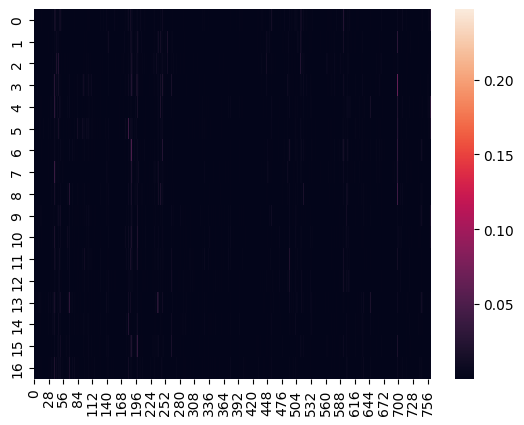

In [31]:
mask =torch.argwhere(test_batch['labels'] != -1)[:, 1] + 1
masked_weights = weights[mask]
sns.heatmap(masked_weights.cpu().numpy())

In [30]:
out

(tensor(0.7867, device='cuda:0'),
 tensor([[[15.3472],
          [15.3528],
          [15.3253],
          ...,
          [13.1115],
          [13.1115],
          [13.1115]],
 
         [[15.2838],
          [15.3108],
          [15.2833],
          ...,
          [13.1115],
          [13.1115],
          [13.1115]],
 
         [[15.3068],
          [15.2396],
          [15.2088],
          ...,
          [13.1115],
          [13.1115],
          [13.1115]],
 
         ...,
 
         [[15.1881],
          [15.3154],
          [14.8486],
          ...,
          [13.1115],
          [13.1115],
          [13.1115]],
 
         [[15.2608],
          [15.3373],
          [15.2942],
          ...,
          [13.1115],
          [13.1115],
          [13.1115]],
 
         [[ 0.0000],
          [10.8531],
          [15.2223],
          ...,
          [13.1115],
          [13.1115],
          [13.1115]]], device='cuda:0'))

In [31]:
out[1].shape

torch.Size([16, 894, 1])

In [28]:
test_batch['input_ids'].shape

torch.Size([16, 894])

In [22]:
relevant_labels = test_batch['labels'][test_batch['labels'] != -1]
preds = (torch.sigmoid(out[1][test_batch['labels']!= -1]) > 0.5).squeeze()

In [24]:
acc = (relevant_labels == preds).sum() / relevant_labels.shape[0]
acc

tensor(0.9141, device='cuda:0')

In [25]:
ones_mask = test_batch['labels'] == 1
ones_preds = torch.sigmoid(out[1][ones_mask]).squeeze()
ones_preds

tensor([0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 0.5000, 1.0000,
        1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 0.9999, 0.9878, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000, 0.5000,
        0.5000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000,
        1.0000, 0.5000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 

In [26]:
zeros_mask = test_batch['labels'] == 0
zeros_preds = torch.sigmoid(out[1][zeros_mask]).squeeze()
zeros_preds

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 

In [27]:
test_preds = torch.load( '../model/logs/encoder_Y_5/preds.pt')

In [28]:
test_preds[0]

tensor([[16.1055, 16.1996, 15.9885,  ..., 15.5607, 15.5607, 15.5607],
        [15.1400, 16.1219, 16.1602,  ..., 15.5607, 15.5607, 15.5607],
        [ 6.0425, 16.1015, 16.0644,  ..., 15.5607, 15.5607, 15.5607],
        ...,
        [16.1255, 16.1500, 16.1519,  ..., 15.5607, 15.5607, 15.5607],
        [14.9631, 16.1762, 16.1520,  ..., 15.5607, 15.5607, 15.5607],
        [ 0.0000, 16.1968, 11.6287,  ..., 15.5607, 15.5607, 15.5607]],
       device='cuda:0')

In [29]:
out[1]

tensor([[[ 4.5498],
         [14.0985],
         [15.0955],
         ...,
         [14.3041],
         [14.3041],
         [14.3041]],

        [[14.0289],
         [14.9152],
         [15.3660],
         ...,
         [14.3041],
         [14.3041],
         [14.3041]],

        [[10.0068],
         [15.1942],
         [13.4600],
         ...,
         [14.3041],
         [14.3041],
         [14.3041]],

        ...,

        [[ 3.9845],
         [14.9787],
         [13.9824],
         ...,
         [14.3041],
         [14.3041],
         [14.3041]],

        [[13.9321],
         [14.9043],
         [14.9813],
         ...,
         [14.3041],
         [14.3041],
         [14.3041]],

        [[ 0.0000],
         [14.0232],
         [ 9.4009],
         ...,
         [14.3041],
         [14.3041],
         [14.3041]]], device='cuda:0')